In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-10-29 17:40:46.649087: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-29 17:40:59.509174: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-29 17:40:59.539286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-10-29 17:40:59.539327: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-29 17:40:59.541509: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-29 17:40:59.543676: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [ ]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [4]:
dataset.x_size

20000

In [5]:
from turing.loss_functions import PDE_Parameter, Parameter_Type
#from turing.utils import Simulation

In [6]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm = L2()
l_inf_norm = L_Inf()

In [21]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)

In [22]:
model = tu.TINN(pinn, 
                pde_loss, 
                loss = l2_norm+ l_inf_norm,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.99,
                loss_penalty_power=1,
                print_precision=".10f")

In [23]:
results = model.train(epochs=8000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=1e-3,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 2.1555156708
total loss: 17.0891307042, total regularisd loss (sum of batches): 98.1351196059
obs u loss: 14.0991380719, obs v loss: 2.9896203812
pde u loss: 0.0003491029, pde v loss: 0.0000231481
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 35.62s

Start of epoch 200
Training observations acc over epoch: 1.6479549408
total loss: 6.5918208611, total regularisd loss (sum of batches): 89.4488094940
obs u loss: 6.3342001253, obs v loss: 0.2576196532
pde u loss: 0.0000005285, pde v loss: 0.0000005541
lambda obs u: 3.5270293735, lambda obs v: 0.1803177662
lambda pde u: 0.1427490153, lambda pde v: 0.1499038451

Time taken: 334.84s

Start of epoch 400
Training observations acc over epoch: 1.6461508274
total loss: 6.5846066135, total regularisd loss (sum of batches): 99.2014734727
obs u loss: 6.3321038967, obs v loss: 0.2524987152
pde u loss: 0.0000016595, pde v


Start of epoch 4400
Training observations acc over epoch: 0.0451314040
total loss: 0.1806221085, total regularisd loss (sum of batches): 3.4941364782
obs u loss: 0.1148884548, obs v loss: 0.0656371610
pde u loss: 0.0000479036, pde v loss: 0.0000485890
lambda obs u: 2.0046193000, lambda obs v: 1.4261204242
lambda pde u: 0.2522491102, lambda pde v: 0.3170111656

Time taken: 321.45s

Start of epoch 4600
Training observations acc over epoch: 0.0421499312
total loss: 0.1686842911, total regularisd loss (sum of batches): 3.1124528733
obs u loss: 0.1002177625, obs v loss: 0.0683819533
pde u loss: 0.0000433495, pde v loss: 0.0000412257
lambda obs u: 1.9381141729, lambda obs v: 1.4909475699
lambda pde u: 0.2547245683, lambda pde v: 0.3162136889

Time taken: 321.41s

Start of epoch 4800
Training observations acc over epoch: 0.0401721150
total loss: 0.1607691107, total regularisd loss (sum of batches): 2.9274540360
obs u loss: 0.0901450214, obs v loss: 0.0705434512
pde u loss: 0.0000415362, pde 

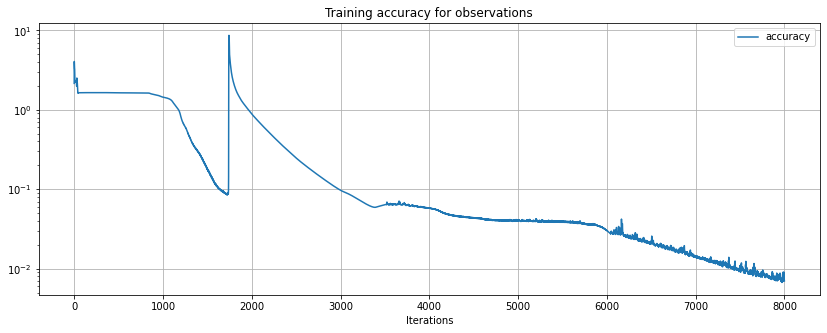

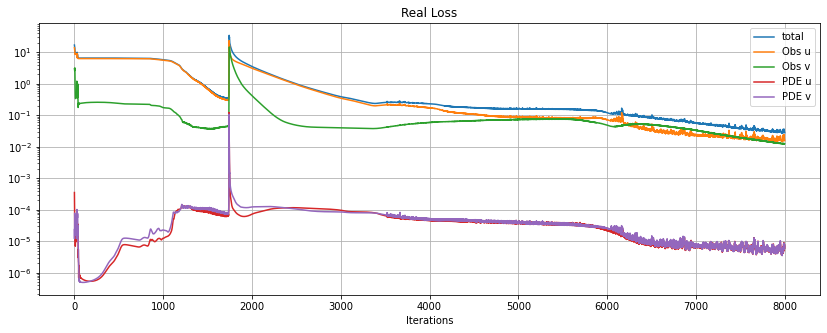

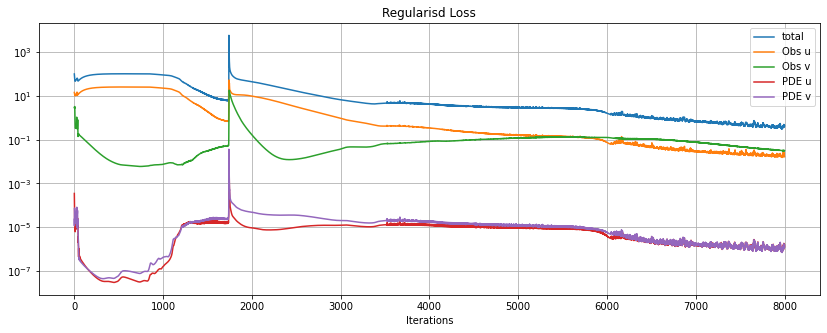

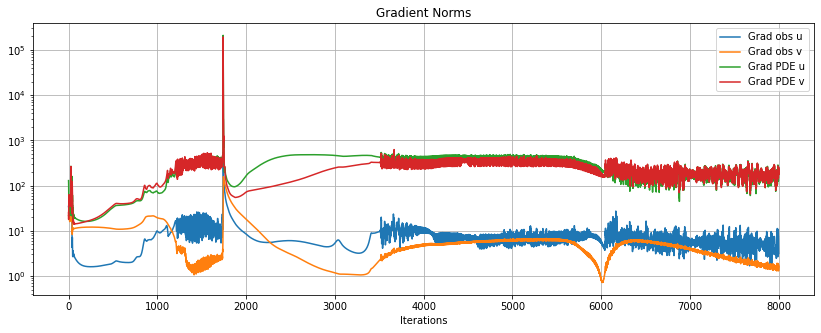

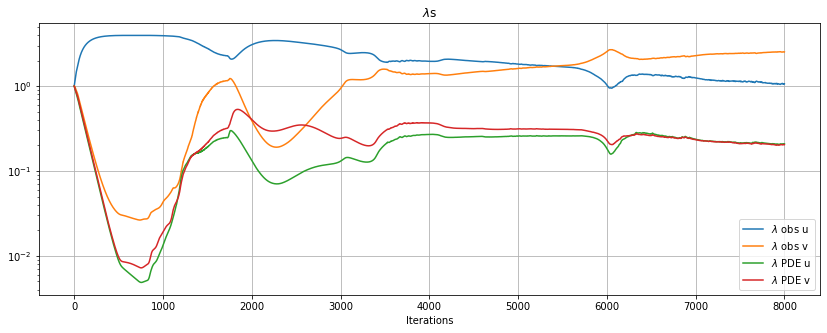

In [24]:
plot_result(results)

In [35]:
results2 = model.train(epochs=4000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-4,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0079263058
total loss: 0.0317154837, total regularisd loss (sum of batches): 0.3759230037
obs u loss: 0.0193953534, obs v loss: 0.0123098734
pde u loss: 0.0000049974, pde v loss: 0.0000052595
lambda obs u: 1.0605148232, lambda obs v: 2.5269102663
lambda pde u: 0.2085731398, lambda pde v: 0.2040017708

Time taken: 1.67s

Start of epoch 200
Training observations acc over epoch: 0.0063352152
total loss: 0.0253522073, total regularisd loss (sum of batches): 0.3561926764
obs u loss: 0.0147657689, obs v loss: 0.0105750901
pde u loss: 0.0000054496, pde v loss: 0.0000058987
lambda obs u: 1.0711206085, lambda obs v: 2.5181328456
lambda pde u: 0.2070254759, lambda pde v: 0.2037210700

Time taken: 319.63s

Start of epoch 400
Training observations acc over epoch: 0.0059677223
total loss: 0.0238794823, total regularisd loss (sum of batches): 0.3191283685
obs u loss: 0.0140358748, obs v loss: 0.0098350144
pde u loss: 0.0000041523, pde v loss:

In [24]:
plot_result(results2,start=3500)

NameError: name 'results2' is not defined

In [47]:
results3 = model.train(epochs=4000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-4,
                      optimizer=optimizer,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0
Training observations acc over epoch: 0.0018501796
total loss: 0.0074049005, total regularisd loss (sum of batches): 0.0990684337
obs u loss: 0.0053014142, obs v loss: 0.0020993044
pde u loss: 0.0000020196, pde v loss: 0.0000021623
lambda obs u: 1.0509496222, lambda obs v: 2.6216187250
lambda pde u: 0.1640874195, lambda pde v: 0.1633442333

Time taken: 1.69s

Start of epoch 200
Training observations acc over epoch: 0.0014830274
total loss: 0.0059336190, total regularisd loss (sum of batches): 0.0608525512
obs u loss: 0.0039764768, obs v loss: 0.0019556327
pde u loss: 0.0000007312, pde v loss: 0.0000007782
lambda obs u: 1.1510698995, lambda obs v: 2.4645790409
lambda pde u: 0.1920772847, lambda pde v: 0.1922737749

Time taken: 319.60s

Start of epoch 400
Training observations acc over epoch: 0.0013872958
total loss: 0.0055506316, total regularisd loss (sum of batches): 0.0593956074
obs u loss: 0.0037091960, obs v loss: 0.0018399868
pde u loss: 0.0000007157, pde v loss:

In [48]:
model.save("/end/home/rh2310/save_tests", "model_100_by_100_1")

In [49]:
import pickle
symbolic_weights = getattr(optimizer, 'weights')
weight_values = tf.keras.backend.batch_get_value(symbolic_weights)
with open('/end/home/rh2310/save_tests/optimizer_100_by_100_1.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

In [ ]:
with open('/end/home/rh2310/save_tests/optimizer_128_by_128_1.pkl', 'rb') as f:
    weight_values = pickle.load(f)
    
optimizer=keras.optimizers.Adam(learning_rate=5e-4)    
optimizer.set_weights(weight_values)

In [50]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

1024.0


In [51]:
#output_test = pinn(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [29]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

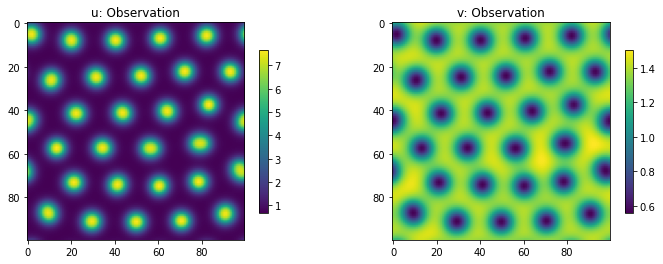

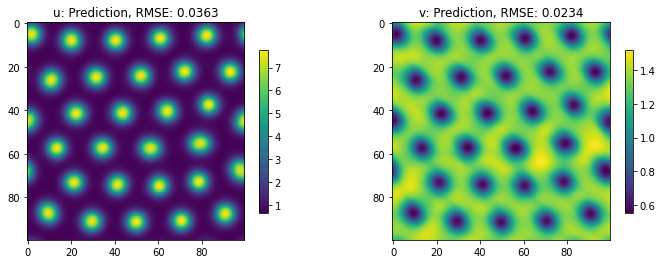

In [52]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [53]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss.residual(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()


In [54]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

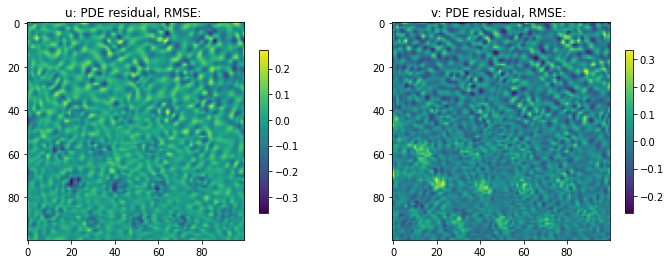

In [55]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

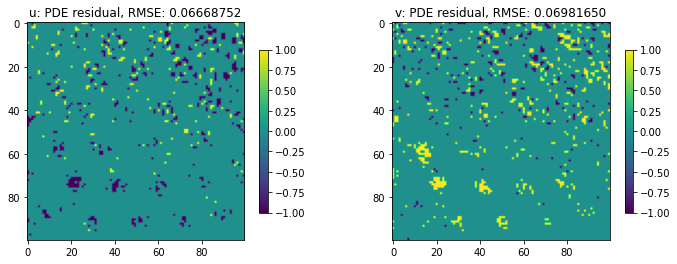

In [58]:
max_L = .12
min_L = -.12

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters estimation

In [2]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [4]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn2 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss2 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype) 
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm2 = L2()
l_inf_norm2 = L_Inf()

In [5]:
optimizer2=keras.optimizers.Adam(learning_rate=5e-4)

In [6]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                loss = l2_norm2+ l_inf_norm2,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.99,
                loss_penalty_power=1,
                print_precision=".10f")

In [36]:
dataset = dataset.cache()

In [37]:
dataset.x_size

20000

In [11]:
results2_1 = model2.train(epochs=20000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=200,
                      stop_threshold=9e-5,
                      optimizer=optimizer2,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True
                     )


Start of epoch 0


2022-10-21 11:26:34.393689: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-21 11:26:52.390211: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 4.2903532982
total loss: 18.7910925450, total regularisd loss (sum of batches): 75.1643701801
obs u loss: 14.2353546511, obs v loss: 2.9260588228
pde u loss: 1.4387026517, pde v loss: 0.1909764195
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
A: 0.99828 B: 0.99819 
Time taken: 40.01s

Start of epoch 200
Training observations acc over epoch: 1.6089261770
total loss: 6.4733050401, total regularisd loss (sum of batches): 88.6368616858
obs u loss: 6.3291842191, obs v loss: 0.1065205673
pde u loss: 0.0161864294, pde v loss: 0.0214138243
lambda obs u: 3.5010818733, lambda obs v: 0.2162489389
lambda pde u: 0.1404221686, lambda pde v: 0.1422470192
A: 1.06722 B: 1.12850 
Time taken: 334.56s

Start of epoch 400
Training observations acc over epoch: 1.6047387123
total loss: 6.4580014222, total regularisd loss (sum of batches): 97.8451444990
obs u loss: 6.3206881663, obs v loss: 0.0982663861
pde u


Start of epoch 4200
Training observations acc over epoch: 0.0183278248
total loss: 0.3579038790, total regularisd loss (sum of batches): 0.8236437858
obs u loss: 0.0268879212, obs v loss: 0.0464233783
pde u loss: 0.1377896052, pde v loss: 0.1468029743
lambda obs u: 1.6582295202, lambda obs v: 1.7924979464
lambda pde u: 0.2725896163, lambda pde v: 0.2766829171
A: 1.17255 B: 2.57646 
Time taken: 321.52s

Start of epoch 4400
Training observations acc over epoch: 0.0149936229
total loss: 0.3021419905, total regularisd loss (sum of batches): 0.6841423617
obs u loss: 0.0255632560, obs v loss: 0.0344112365
pde u loss: 0.1186750352, pde v loss: 0.1234924628
lambda obs u: 1.5260981500, lambda obs v: 1.9325314827
lambda pde u: 0.2683224083, lambda pde v: 0.2730479591
A: 1.17628 B: 2.60611 
Time taken: 321.67s

Start of epoch 4600
Training observations acc over epoch: 0.0136151947
total loss: 0.4599266484, total regularisd loss (sum of batches): 0.7854695445
obs u loss: 0.0281374883, obs v loss:


Start of epoch 8400
Training observations acc over epoch: 0.0021189894
total loss: 0.0860182610, total regularisd loss (sum of batches): 0.1388688597
obs u loss: 0.0060529119, obs v loss: 0.0024230457
pde u loss: 0.0357077396, pde v loss: 0.0418345637
lambda obs u: 1.3967955040, lambda obs v: 2.0571917754
lambda pde u: 0.2631845440, lambda pde v: 0.2828281766
A: 1.18657 B: 2.75327 
Time taken: 321.43s

Start of epoch 8600
Training observations acc over epoch: 0.0018537606
total loss: 0.0497832152, total regularisd loss (sum of batches): 0.0897443109
obs u loss: 0.0052220786, obs v loss: 0.0021929637
pde u loss: 0.0191636351, pde v loss: 0.0232045378
lambda obs u: 1.3790440647, lambda obs v: 2.1251234555
lambda pde u: 0.2332880265, lambda pde v: 0.2625444533
A: 1.18599 B: 2.75582 
Time taken: 321.41s

Start of epoch 8800
Training observations acc over epoch: 0.0016190262
total loss: 0.0411636454, total regularisd loss (sum of batches): 0.0789912285
obs u loss: 0.0042837345, obs v loss:


Start of epoch 12600
Training observations acc over epoch: 0.0022644401
total loss: 0.1294635557, total regularisd loss (sum of batches): 0.1955846676
obs u loss: 0.0074956955, obs v loss: 0.0015620646
pde u loss: 0.0584636973, pde v loss: 0.0619420983
lambda obs u: 1.3728034575, lambda obs v: 2.0360754629
lambda pde u: 0.2796759183, lambda pde v: 0.3114451613
A: 1.17835 B: 2.80483 
Time taken: 321.42s

Start of epoch 12800
Training observations acc over epoch: 0.0030392786
total loss: 0.2120099236, total regularisd loss (sum of batches): 0.3383842975
obs u loss: 0.0106873914, obs v loss: 0.0014697227
pde u loss: 0.0961991961, pde v loss: 0.1036536134
lambda obs u: 1.4998611397, lambda obs v: 1.8377814022
lambda pde u: 0.3149430593, lambda pde v: 0.3474143988
A: 1.17816 B: 2.80722 
Time taken: 321.40s

Start of epoch 13000
Training observations acc over epoch: 0.0007025058
total loss: 0.0158141997, total regularisd loss (sum of batches): 0.0320264126
obs u loss: 0.0018911115, obs v lo


Start of epoch 16800
Training observations acc over epoch: 0.0004118354
total loss: 0.0092369367, total regularisd loss (sum of batches): 0.0182464161
obs u loss: 0.0010778958, obs v loss: 0.0005694458
pde u loss: 0.0040143767, pde v loss: 0.0035752183
lambda obs u: 1.3601493529, lambda obs v: 2.1442151828
lambda pde u: 0.2271328826, lambda pde v: 0.2685025817
A: 1.16986 B: 2.84556 
Time taken: 321.41s

Start of epoch 17000
Training observations acc over epoch: 0.0004626625
total loss: 0.0104064899, total regularisd loss (sum of batches): 0.0228249392
obs u loss: 0.0012264975, obs v loss: 0.0006241524
pde u loss: 0.0044291616, pde v loss: 0.0041266783
lambda obs u: 1.3753000685, lambda obs v: 1.9727510157
lambda pde u: 0.3082938975, lambda pde v: 0.3436550183
A: 1.16952 B: 2.84749 
Time taken: 321.42s

Start of epoch 17200
Training observations acc over epoch: 0.0004105190
total loss: 0.0106558459, total regularisd loss (sum of batches): 0.0178586836
obs u loss: 0.0011116097, obs v lo

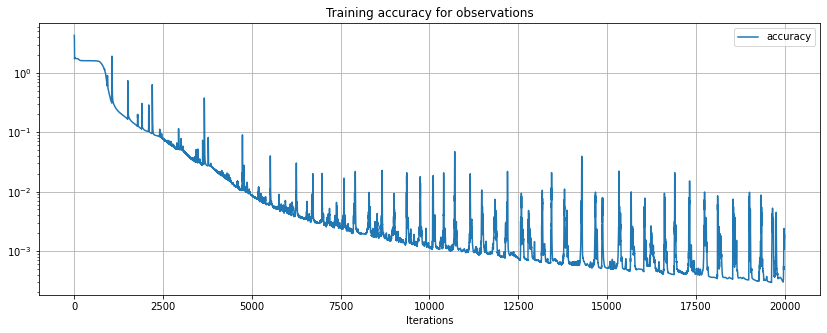

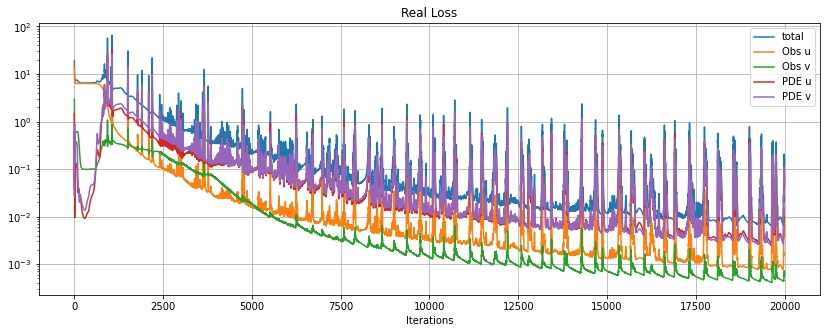

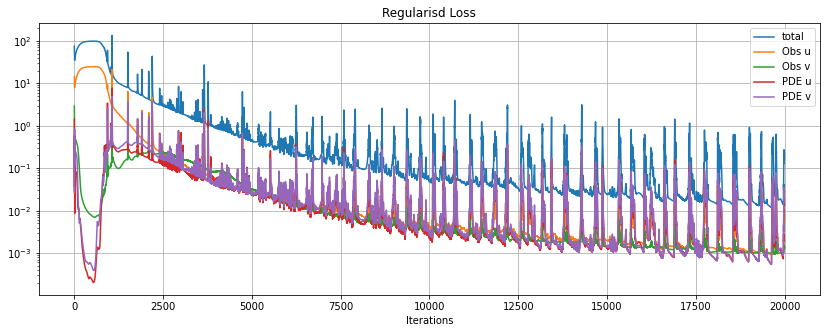

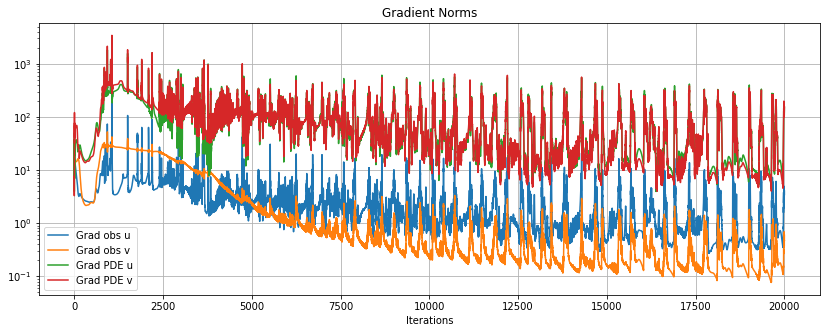

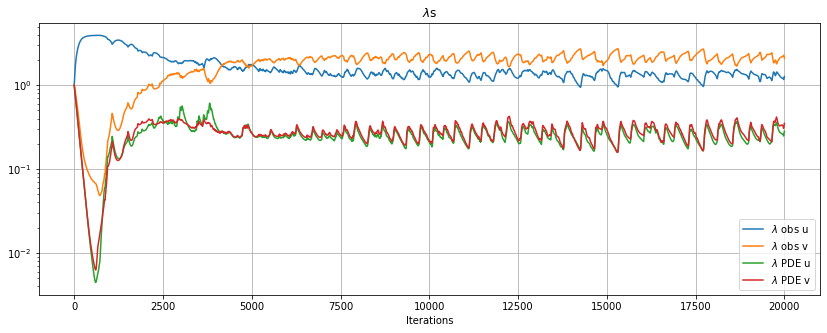

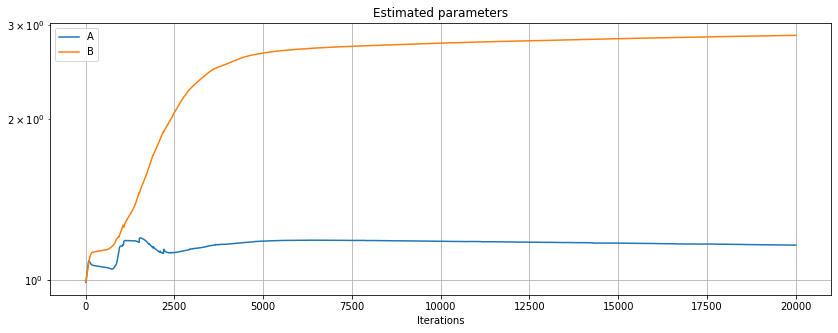

In [12]:
plot_result(results2_1, param_names=["A", "B"])

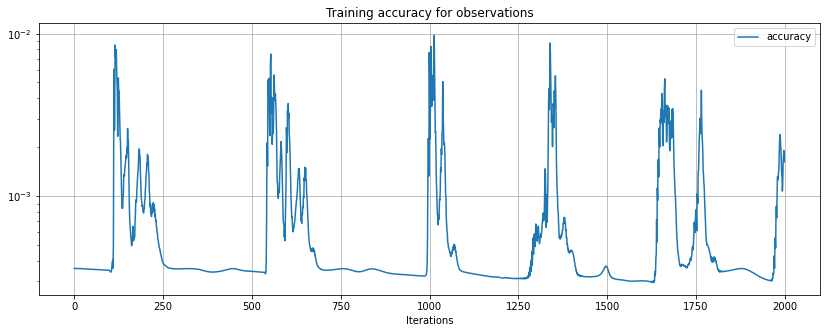

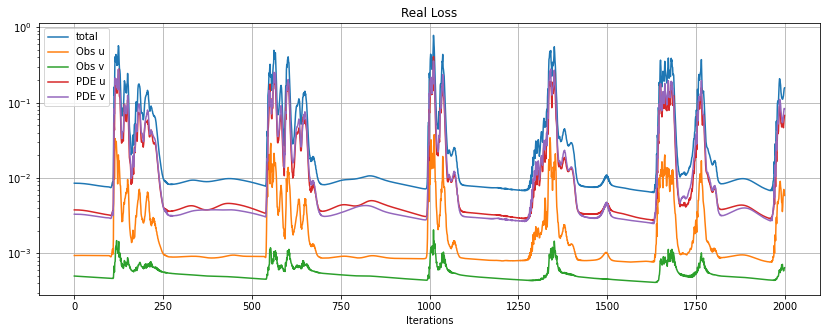

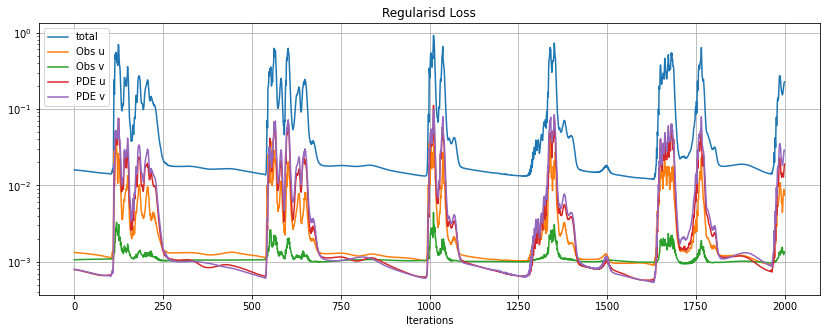

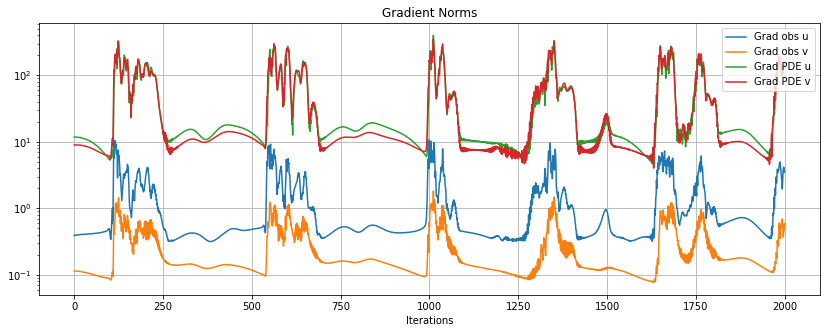

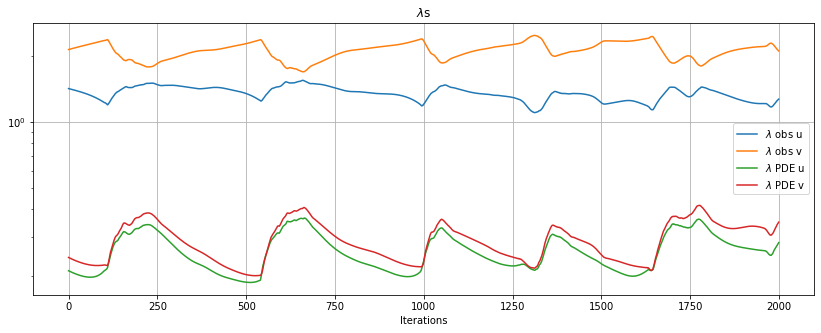

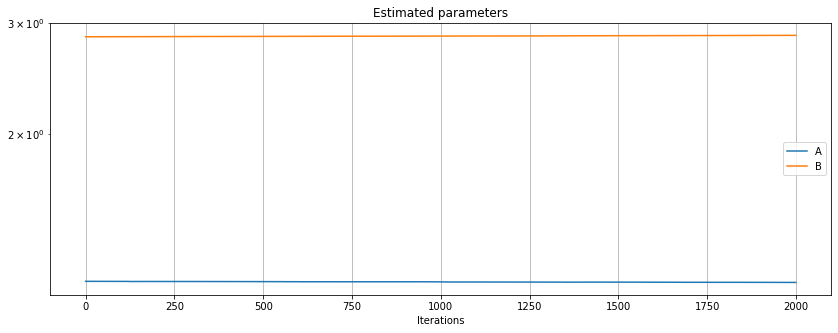

In [13]:
plot_result(results2_1, param_names=["A", "B"], start=18000)

In [17]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

A = 1.1636118048437447
B = 2.8708527112044462


In [18]:
model2.save("/end/home/rh2310/save_tests", "model_100_by_100_2")

In [19]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

512.0


In [20]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [21]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

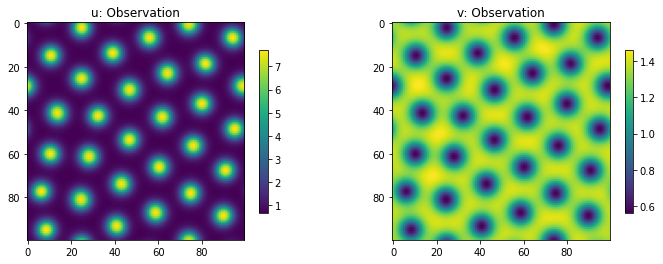

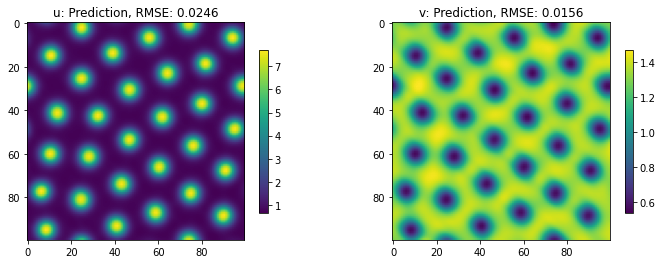

In [22]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [30]:
test_outputs, test_pde_u, test_pde_v = pde_loss2.residual(pinn2, np.vstack([XX_test, YY_test, TT_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

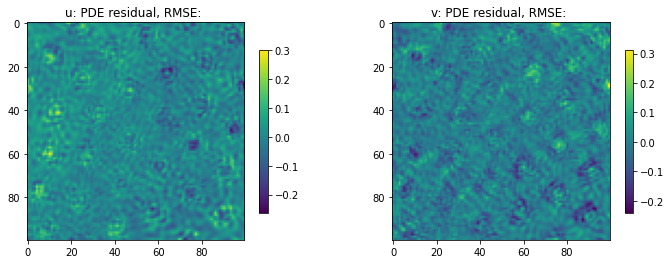

In [32]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

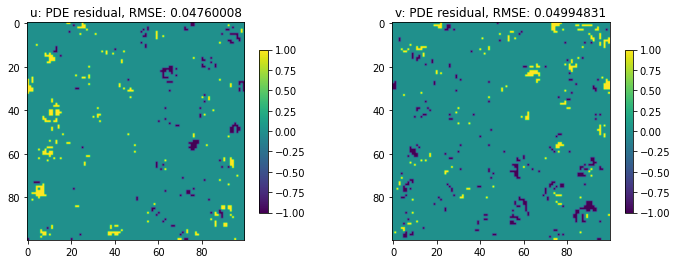

In [33]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters as input

In [2]:
import os
dataset = TINN_Multiple_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100_dense"),
                                 ["Brusselator_1"] +
                                 [f"Brusselator_1_{id}" for id in range(1,61)],
                                 param_names = ["A", "B"],
                                 pde_ratio = 0,
                                 thining_start=-2)

In [3]:
dataset.x_size

1220000

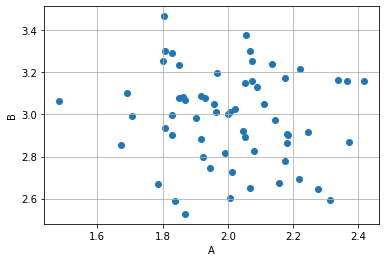

In [4]:
As = [s.parameters["A"] for s in dataset.simulations]
Bs = [s.parameters["B"] for s in dataset.simulations]
plt.scatter(As, Bs)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [5]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [5, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn3 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss3 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[0],dtype=pinn3.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[1],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype),
                       A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn3.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype) 
                       B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm3 = L2()
l_inf_norm3 = L_Inf()

In [6]:
model3 = tu.TINN(pinn3, 
                pde_loss3, 
                loss = l2_norm3+ l_inf_norm3,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset = dataset.cache()

In [8]:
results3_1 = model3.train(epochs=2000+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0


2022-10-25 16:54:14.289397: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-25 16:54:26.950497: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1.6530870199
total loss: 6.9169794368, total regularisd loss (sum of batches): 2636.0631352606
obs u loss: 6.3364546754, obs v loss: 0.2758937765
pde u loss: 0.1407621626, pde v loss: 0.1638688222
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 151.47s

Start of epoch 10
Training observations acc over epoch: 1.5920084715
total loss: 6.3995398850, total regularisd loss (sum of batches): 2439.3650864083
obs u loss: 6.1481721523, obs v loss: 0.2198615170
pde u loss: 0.0215402650, pde v loss: 0.0099659507
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 317.21s

Start of epoch 20
Training observations acc over epoch: 1.5918910503
total loss: 6.3964524928, total regularisd loss (sum of batches): 2438.1937210718
obs u loss: 6.1475305056, obs v loss: 0.2200321439
pde u loss: 0.0202191470, pde v loss: 0.008670


Start of epoch 220
Training observations acc over epoch: 0.1004494280
total loss: 1.9002548007, total regularisd loss (sum of batches): 480.4835425997
obs u loss: 0.3300951770, obs v loss: 0.0717026496
pde u loss: 0.7611256117, pde v loss: 0.7373313625
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 394.59s

Start of epoch 230
Training observations acc over epoch: 0.0972554460
total loss: 1.8379153961, total regularisd loss (sum of batches): 460.9317989861
obs u loss: 0.3192731234, obs v loss: 0.0697486675
pde u loss: 0.7309814705, pde v loss: 0.7179121346
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 311.70s

Start of epoch 240
Training observations acc over epoch: 0.0939480960
total loss: 1.7923214690, total regularisd loss (sum of batches): 447.0453345112
obs u loss: 0.3070504384, obs v loss: 0.0687419320
pde u loss: 0.7164480774, p


Start of epoch 440
Training observations acc over epoch: 0.0658497214
total loss: 1.2543070838, total regularisd loss (sum of batches): 295.8402871995
obs u loss: 0.2138059572, obs v loss: 0.0495929763
pde u loss: 0.4871784499, pde v loss: 0.5037297004
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 394.61s

Start of epoch 450
Training observations acc over epoch: 0.0652208701
total loss: 1.2427952027, total regularisd loss (sum of batches): 292.2581465893
obs u loss: 0.2119532768, obs v loss: 0.0489302329
pde u loss: 0.4826421902, pde v loss: 0.4992695028
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 311.65s

Start of epoch 460
Training observations acc over epoch: 0.0647840127
total loss: 1.2418534768, total regularisd loss (sum of batches): 291.2249851964
obs u loss: 0.2106797370, obs v loss: 0.0484562630
pde u loss: 0.4817046914, p


Start of epoch 660
Training observations acc over epoch: 0.0561888367
total loss: 1.0174607997, total regularisd loss (sum of batches): 236.1266280370
obs u loss: 0.1859758418, obs v loss: 0.0387795000
pde u loss: 0.3823813609, pde v loss: 0.4103240970
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 394.57s

Start of epoch 670
Training observations acc over epoch: 0.0560807511
total loss: 1.0058793401, total regularisd loss (sum of batches): 233.6032099734
obs u loss: 0.1859717676, obs v loss: 0.0383512080
pde u loss: 0.3767449392, pde v loss: 0.4048114254
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 311.60s

Start of epoch 680
Training observations acc over epoch: 0.0558536425
total loss: 1.0031872503, total regularisd loss (sum of batches): 232.8038092963
obs u loss: 0.1853455389, obs v loss: 0.0380690029
pde u loss: 0.3756860046, p


Start of epoch 880
Training observations acc over epoch: 0.0514696464
total loss: 0.8894505057, total regularisd loss (sum of batches): 202.8654519637
obs u loss: 0.1742257806, obs v loss: 0.0316528194
pde u loss: 0.3242585726, pde v loss: 0.3593133331
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 394.62s

Start of epoch 890
Training observations acc over epoch: 0.0512904339
total loss: 0.8804311046, total regularisd loss (sum of batches): 197.5671903454
obs u loss: 0.1743230075, obs v loss: 0.0308386091
pde u loss: 0.3176413752, pde v loss: 0.3576281129
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 311.80s

Start of epoch 900
Training observations acc over epoch: 0.0514472835
total loss: 0.8896521595, total regularisd loss (sum of batches): 198.8646825162
obs u loss: 0.1751968424, obs v loss: 0.0305923015
pde u loss: 0.3202554189, p


Start of epoch 1100
Training observations acc over epoch: 0.0477724373
total loss: 0.8003582203, total regularisd loss (sum of batches): 178.9733392156
obs u loss: 0.1641161336, obs v loss: 0.0269736955
pde u loss: 0.2880082373, pde v loss: 0.3212601540
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 394.51s

Start of epoch 1110
Training observations acc over epoch: 0.0475688428
total loss: 0.7983455372, total regularisd loss (sum of batches): 178.1628841155
obs u loss: 0.1634468951, obs v loss: 0.0268284586
pde u loss: 0.2869519171, pde v loss: 0.3211182663
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 311.66s

Start of epoch 1120
Training observations acc over epoch: 0.0474360101
total loss: 0.7964283105, total regularisd loss (sum of batches): 177.7053861763
obs u loss: 0.1630777693, obs v loss: 0.0266661796
pde u loss: 0.2865030301


Start of epoch 1320
Training observations acc over epoch: 0.0455110148
total loss: 0.7538807050, total regularisd loss (sum of batches): 155.7127477386
obs u loss: 0.1598271535, obs v loss: 0.0222169103
pde u loss: 0.2635596888, pde v loss: 0.3082769525
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 394.48s

Start of epoch 1330
Training observations acc over epoch: 0.0448879078
total loss: 0.7387774338, total regularisd loss (sum of batches): 154.5396627040
obs u loss: 0.1573802909, obs v loss: 0.0221713188
pde u loss: 0.2588372560, pde v loss: 0.3003885680
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 311.58s

Start of epoch 1340
Training observations acc over epoch: 0.0445171669
total loss: 0.7253139308, total regularisd loss (sum of batches): 152.3820484406
obs u loss: 0.1560130776, obs v loss: 0.0220555801
pde u loss: 0.2539548378


Start of epoch 1540
Training observations acc over epoch: 0.0426075123
total loss: 0.6908485049, total regularisd loss (sum of batches): 145.6772664575
obs u loss: 0.1511126833, obs v loss: 0.0193173818
pde u loss: 0.2408860269, pde v loss: 0.2795324128
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 394.54s

Start of epoch 1550
Training observations acc over epoch: 0.0420685150
total loss: 0.6790270362, total regularisd loss (sum of batches): 139.7365763114
obs u loss: 0.1495056483, obs v loss: 0.0187683683
pde u loss: 0.2357664177, pde v loss: 0.2749866019
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 311.59s

Start of epoch 1560
Training observations acc over epoch: 0.0414840579
total loss: 0.6594580196, total regularisd loss (sum of batches): 136.5948282557
obs u loss: 0.1473855009, obs v loss: 0.0185506702
pde u loss: 0.2283523759


Start of epoch 1760
Training observations acc over epoch: 0.0393189341
total loss: 0.6250674107, total regularisd loss (sum of batches): 123.7238082992
obs u loss: 0.1415296629, obs v loss: 0.0157460922
pde u loss: 0.2154790040, pde v loss: 0.2523126515
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 394.55s

Start of epoch 1770
Training observations acc over epoch: 0.0391497463
total loss: 0.6229552947, total regularisd loss (sum of batches): 124.7181565792
obs u loss: 0.1408568058, obs v loss: 0.0157422266
pde u loss: 0.2151681511, pde v loss: 0.2511881112
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 311.63s

Start of epoch 1780
Training observations acc over epoch: 0.0389567055
total loss: 0.6204336963, total regularisd loss (sum of batches): 124.1473496880
obs u loss: 0.1402213753, obs v loss: 0.0156055217
pde u loss: 0.2145223684


Start of epoch 1980
Training observations acc over epoch: 0.0351502448
total loss: 0.5783167923, total regularisd loss (sum of batches): 112.3554556352
obs u loss: 0.1274023707, obs v loss: 0.0131986525
pde u loss: 0.2018498678, pde v loss: 0.2358659013
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 394.48s

Start of epoch 1990
Training observations acc over epoch: 0.0350281410
total loss: 0.5717861999, total regularisd loss (sum of batches): 111.0682235894
obs u loss: 0.1270204285, obs v loss: 0.0130921714
pde u loss: 0.1996526894, pde v loss: 0.2320209106
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 311.58s

Start of epoch 2000
Training observations acc over epoch: 0.0354647674
total loss: 0.5961633153, total regularisd loss (sum of batches): 114.3155374174
obs u loss: 0.1288202927, obs v loss: 0.0130387801
pde u loss: 0.2083353812

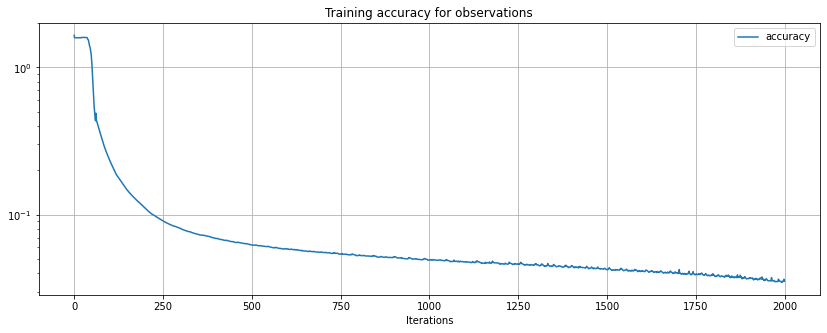

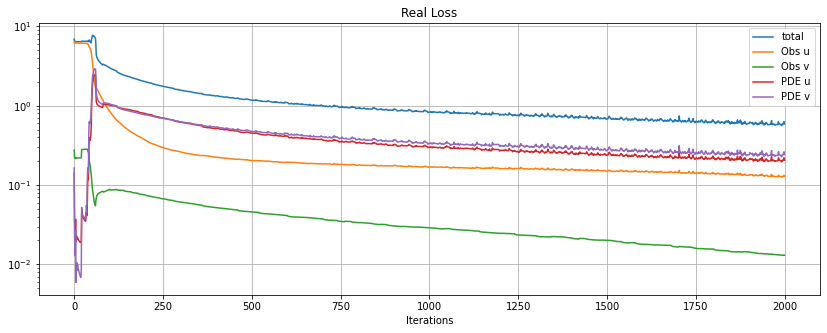

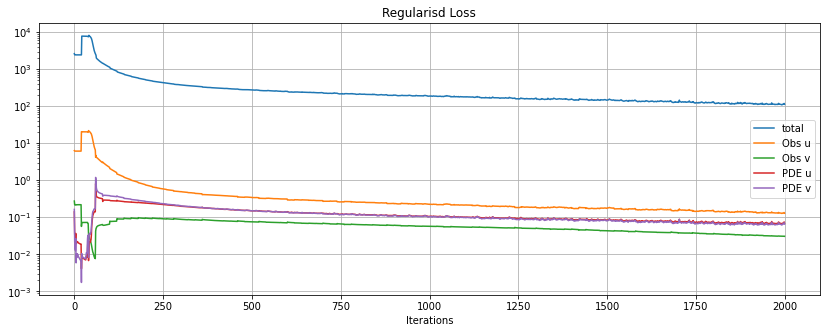

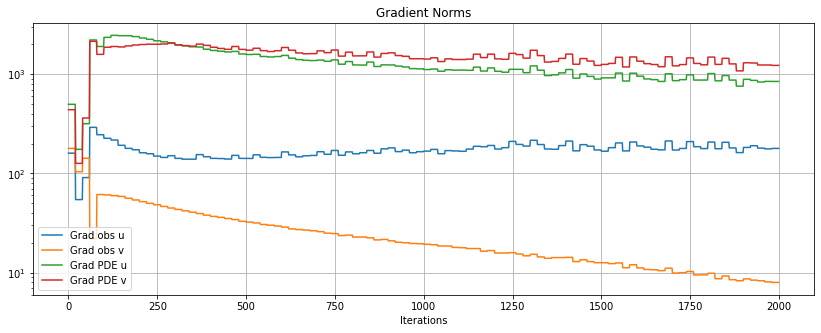

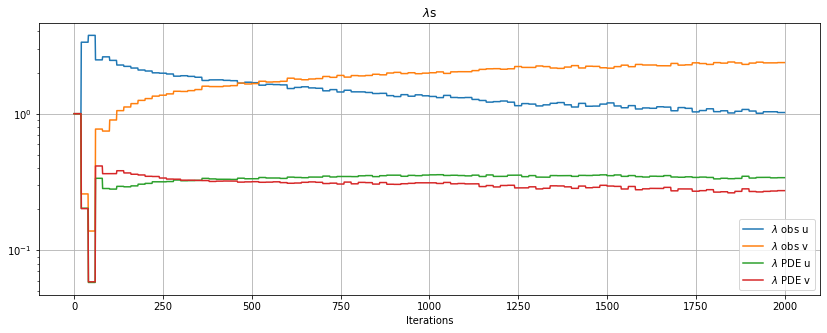

In [9]:
plot_result(results3_1)

In [63]:
model3.optimizer.lr.assign(2.5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [64]:
results3_2 = model3.train(epochs=200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0322781578
total loss: 0.4840717539, total regularisd loss (sum of batches): 94.4522916826
obs u loss: 0.1163890541, obs v loss: 0.0127235690
pde u loss: 0.1676925989, pde v loss: 0.1872665317
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 113.12s

Start of epoch 10
Training observations acc over epoch: 0.0326887965
total loss: 0.5080922170, total regularisd loss (sum of batches): 97.3856840410
obs u loss: 0.1182746592, obs v loss: 0.0124805028
pde u loss: 0.1773264070, pde v loss: 0.2000106480
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 311.68s

Start of epoch 20
Training observations acc over epoch: 0.0324047469
total loss: 0.5051628569, total regularisd loss (sum of batches): 96.6937161107
obs u loss: 0.1172730712, obs v loss: 0.0123458027
pde u loss: 0.1766595618, pde v lo

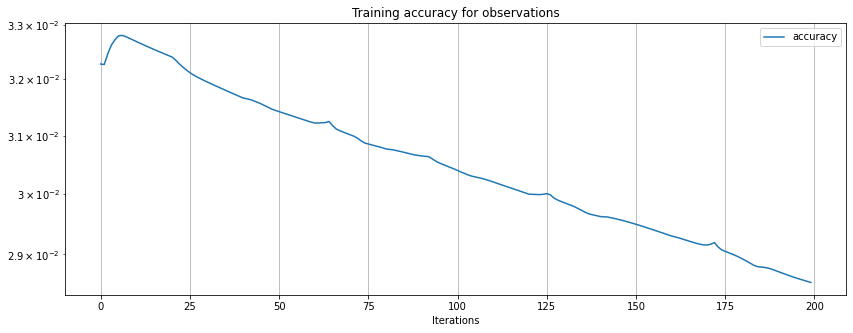

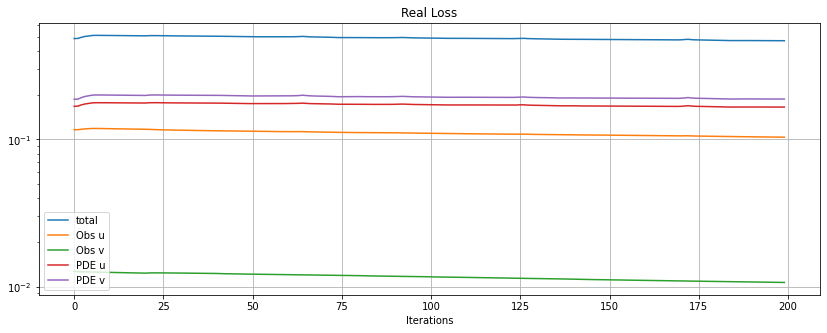

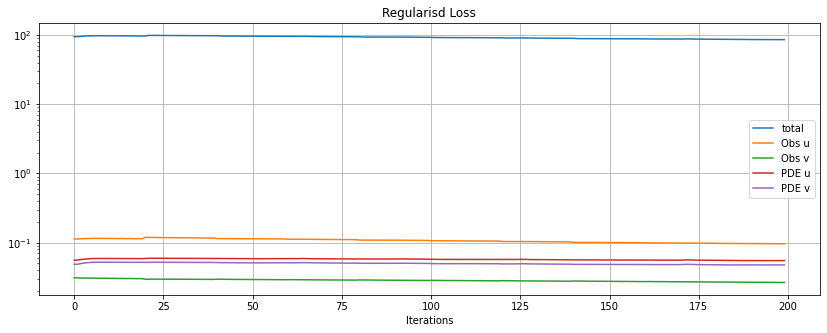

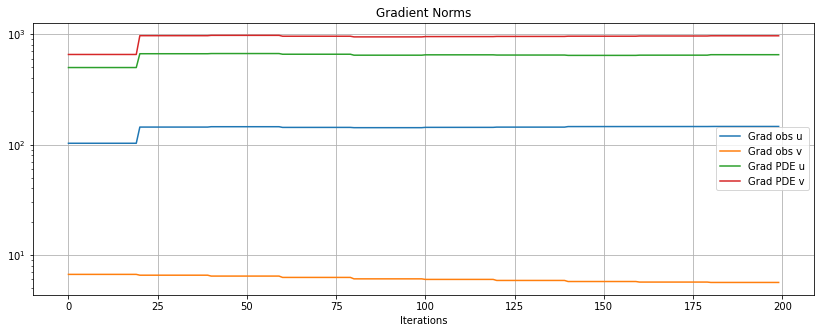

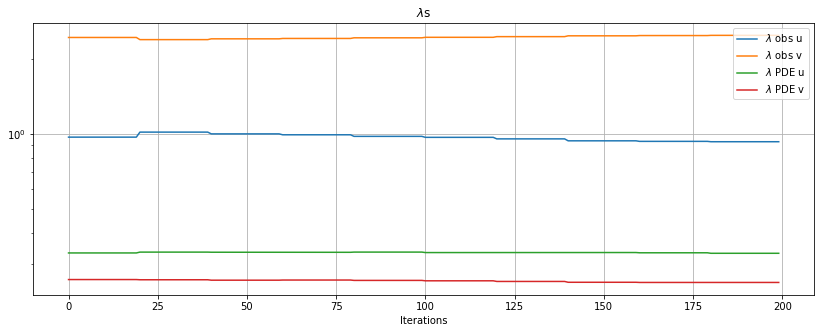

In [68]:
plot_result(results3_2)

In [94]:
results3_3 = model3.train(epochs=1200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0285328384
total loss: 0.4678100458, total regularisd loss (sum of batches): 84.7940857677
obs u loss: 0.1034920889, obs v loss: 0.0106392991
pde u loss: 0.1656176198, pde v loss: 0.1880610381
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 112.90s

Start of epoch 10
Training observations acc over epoch: 0.0283601247
total loss: 0.4649730639, total regularisd loss (sum of batches): 84.2425643119
obs u loss: 0.1029159118, obs v loss: 0.0105245697
pde u loss: 0.1643992361, pde v loss: 0.1871333464
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 313.07s

Start of epoch 20
Training observations acc over epoch: 0.0281619262
total loss: 0.4623293477, total regularisd loss (sum of batches): 83.7114446626
obs u loss: 0.1022099763, obs v loss: 0.0104377007
pde u loss: 0.1635083252, pde v lo


Start of epoch 220
Training observations acc over epoch: 0.0251143556
total loss: 0.4219619763, total regularisd loss (sum of batches): 73.3083929888
obs u loss: 0.0916249703, obs v loss: 0.0088324323
pde u loss: 0.1488928301, pde v loss: 0.1726117435
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 396.52s

Start of epoch 230
Training observations acc over epoch: 0.0251756068
total loss: 0.4217950451, total regularisd loss (sum of batches): 74.5562242723
obs u loss: 0.0918744623, obs v loss: 0.0088279870
pde u loss: 0.1488237782, pde v loss: 0.1722688176
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 313.15s

Start of epoch 240
Training observations acc over epoch: 0.0249764081
total loss: 0.4169718047, total regularisd loss (sum of batches): 73.8081341424
obs u loss: 0.0911357573, obs v loss: 0.0087699093
pde u loss: 0.1470838240, pde 


Start of epoch 440
Training observations acc over epoch: 0.0227104146
total loss: 0.3868540005, total regularisd loss (sum of batches): 66.3048705571
obs u loss: 0.0832158822, obs v loss: 0.0076257659
pde u loss: 0.1366657915, pde v loss: 0.1593465609
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 396.54s

Start of epoch 450
Training observations acc over epoch: 0.0226314366
total loss: 0.3850294935, total regularisd loss (sum of batches): 66.8943855088
obs u loss: 0.0829036773, obs v loss: 0.0076220637
pde u loss: 0.1361974567, pde v loss: 0.1583062959
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 313.17s

Start of epoch 460
Training observations acc over epoch: 0.0225026235
total loss: 0.3830203592, total regularisd loss (sum of batches): 66.5451385123
obs u loss: 0.0824281274, obs v loss: 0.0075823763
pde u loss: 0.1357903855, pde 


Start of epoch 660
Training observations acc over epoch: 0.0207161922
total loss: 0.3546563628, total regularisd loss (sum of batches): 62.7248037174
obs u loss: 0.0759433739, obs v loss: 0.0069213645
pde u loss: 0.1260980700, pde v loss: 0.1456935543
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 396.54s

Start of epoch 670
Training observations acc over epoch: 0.0206491258
total loss: 0.3548000972, total regularisd loss (sum of batches): 62.4845574546
obs u loss: 0.0757022339, obs v loss: 0.0068942586
pde u loss: 0.1261097452, pde v loss: 0.1460938595
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 313.19s

Start of epoch 680
Training observations acc over epoch: 0.0206973478
total loss: 0.3573011576, total regularisd loss (sum of batches): 62.8035123872
obs u loss: 0.0759108501, obs v loss: 0.0068785471
pde u loss: 0.1268763167, pde 


Start of epoch 880
Training observations acc over epoch: 0.0194194354
total loss: 0.3442417988, total regularisd loss (sum of batches): 58.3349458895
obs u loss: 0.0714120350, obs v loss: 0.0062656940
pde u loss: 0.1220108676, pde v loss: 0.1445532021
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 396.76s

Start of epoch 890
Training observations acc over epoch: 0.0190791693
total loss: 0.3377329857, total regularisd loss (sum of batches): 56.0442757276
obs u loss: 0.0701283817, obs v loss: 0.0061883117
pde u loss: 0.1199527043, pde v loss: 0.1414635881
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 313.29s

Start of epoch 900
Training observations acc over epoch: 0.0190564077
total loss: 0.3414207909, total regularisd loss (sum of batches): 56.4072817622
obs u loss: 0.0700667814, obs v loss: 0.0061588645
pde u loss: 0.1212063934, pde 


Start of epoch 1100
Training observations acc over epoch: 0.0179258157
total loss: 0.3162235213, total regularisd loss (sum of batches): 53.4342459159
obs u loss: 0.0658925268, obs v loss: 0.0058107600
pde u loss: 0.1124111851, pde v loss: 0.1321090494
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 396.52s

Start of epoch 1110
Training observations acc over epoch: 0.0182743017
total loss: 0.3278474280, total regularisd loss (sum of batches): 56.7880747075
obs u loss: 0.0672222083, obs v loss: 0.0058749904
pde u loss: 0.1165716057, pde v loss: 0.1381786235
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 313.20s

Start of epoch 1120
Training observations acc over epoch: 0.0178609528
total loss: 0.3148141516, total regularisd loss (sum of batches): 54.9149183047
obs u loss: 0.0655889581, obs v loss: 0.0058548318
pde u loss: 0.1119411587, p

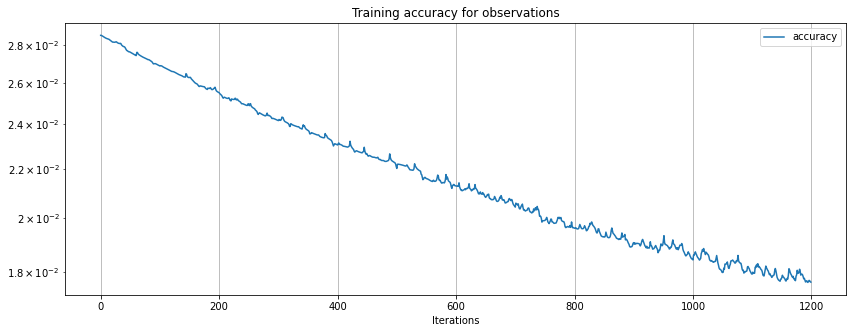

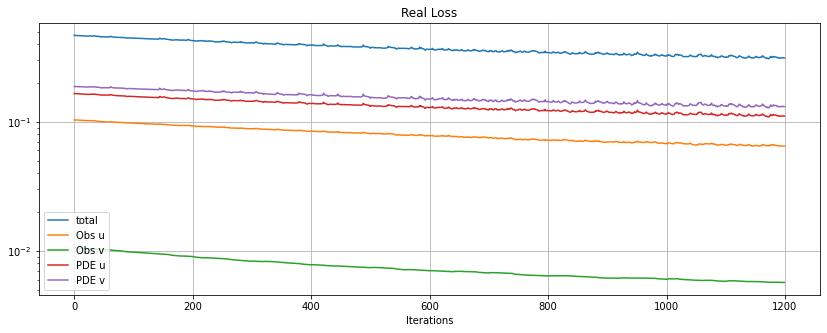

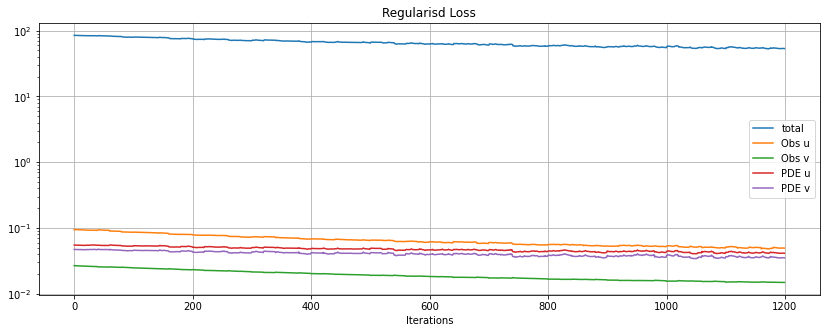

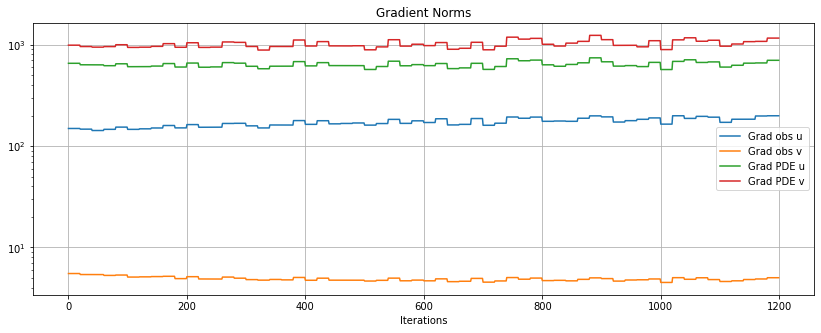

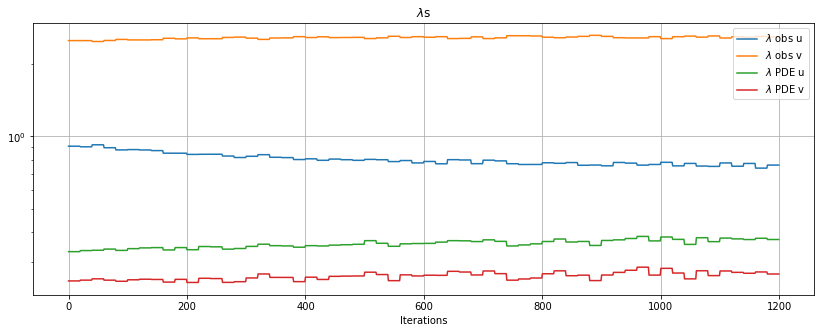

In [96]:
plot_result(results3_3)

In [95]:
model3.save("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")

In [ ]:
## model3 = tu.TINN.restore("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")
pinn3 = model3.pinn
pde_loss3 = model3.pde_residual

640.0
2.0500405063689455 2.8141502795583957


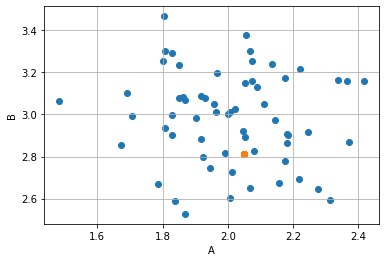

In [131]:
x_domain = dataset.simulations[0].L[0] * np.linspace(0, 1, dataset.simulations[0].n[0])
y_domain = dataset.simulations[0].L[1] * np.linspace(0, 1, dataset.simulations[0].n[1])
x_size = dataset.simulations[0].n[0]
y_size = dataset.simulations[0].n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ls_ts[0][T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ls_ts[0][T_test_index], N2)  # 1 x N2

#A_test = np.repeat(dataset.simulations[0].parameters["A"] + 1, N2)
A_M = 2
B_M = 3
std_AB = .1
(A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
while A in As and B in Bs and std_AB > 0:
    (A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
    
print(A, B)
A_test = np.repeat(A, N2)
#B_test = np.repeat(dataset.simulations[0].parameters["B"] + 1, N2)
B_test = np.repeat(B, N2)

plt.scatter(As, Bs)
plt.scatter(A_test, B_test)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [132]:
output_test = pinn3(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

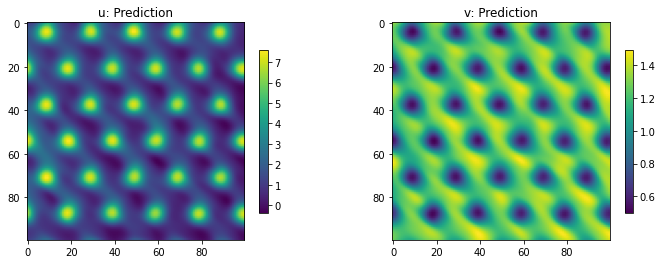

In [133]:
node_names = ["u", "v"]
# _ = plt.figure(figsize=(12,4))
# for i, name in enumerate(node_names):
#     plt.subplot(1, 2, i+1)
#     plt.title(f"{name}: Observation")
#     plt.imshow(data[i,:, :, T_test_index])
#     plt.colorbar(shrink=.75)

# plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    #plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    plt.title(f"{name}: Prediction")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [134]:
test_outputs, test_pde_u, test_pde_v = pde_loss3.residual(pinn3, np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

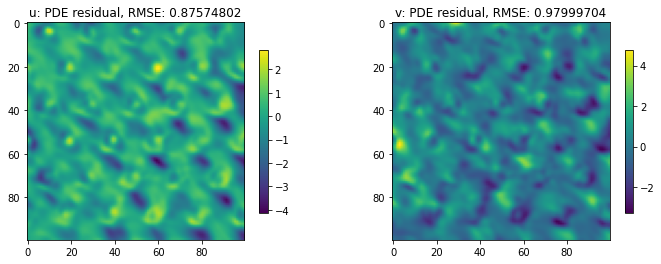

In [135]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

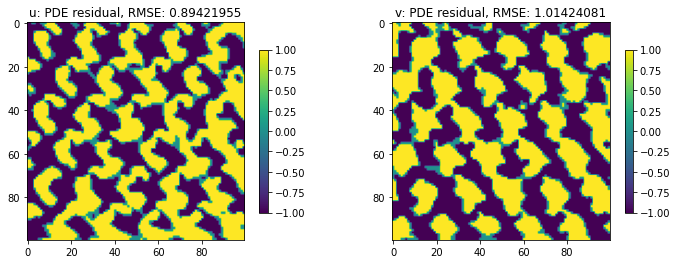

In [120]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()